In [1]:
import os
import warnings #Inorer les messages d'alerte
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt # pour les visualisations graphiques
from matplotlib.backends.backend_pdf import PdfPages # enregistrer les figures dans un PDF 
from scipy.optimize import minimize # permet de faire l'optimisation en max le Rdt
from numpy.linalg import norm
warnings.filterwarnings('ignore')

In [2]:
# IMPORTATION DES DONNEES
# Chemin vers ton dossier CSV
csv_folder = r"C:\Users\HP\Desktop\CODE PYTHON MEMO\csv"  # adapte si besoin

# Correspondance nom de fichier → ticker #création d'un dictionnaire contenant tous les tickers
# fait le lien entre nom fichier csv et tickers boursiers
file_ticker_map = {
    "Airbus Group Stock Price History.csv": "AIR.PA",
    "EssilorLuxottica Stock Price History.csv": "EL.PA",
    "Hermes International Stock Price History.csv": "RMS.PA",
    "Kering Stock Price History.csv": "KER.PA",
    "L'Oreal Stock Price History.csv": "OR.PA",
    "Louis Vuitton Stock Price History.csv": "MC.PA",
    "Safran Stock Price History.csv": "SAF.PA",
    "Sanofi Stock Price History.csv": "SAN.PA",
    "Schneider Electric Stock Price History.csv": "SU.PA",
    "TotalEnergies SE Stock Price History.csv": "TTE.PA"
}

In [3]:
#crée une fonction qui extrait les pris de cloture des fichiers csv
# 'None' rend la fonction générale pour faciliter la comparaison dans la suite de l'étude 
def get_prices(tickers, start=None, end=None):
    close_data = {}

    # Inverser le mapping pour avoir ticker → fichier
    # On inverse le dictionnaire pour avoir un acces direct au fichier en appelant le dictionnaire 
    # le code devient plus automatisé car on n'aplus besoin d'appeler les tickers un a un 
    ticker_to_file = {v: k for k, v in file_ticker_map.items()}
    
# Assembler tous les prix de clotures dans un seul dataframe ou chaque actif a son prix de cloture
# indexé par date et si l'actif ne se trouve pas dans le dictionnaire, on l'ignore
    for ticker in tickers:
        if ticker not in ticker_to_file:
            print(f"Ticker inconnu ou non pris en charge : {ticker}")
            continue
            
  # chargement du csv      
        filename = ticker_to_file[ticker]
        file_path = os.path.join(csv_folder, filename)
        
# empeche le script de s'arreter avec une erreur dans les données
# affiche l'erreur la skippe et continu
        try:
            df = pd.read_csv(file_path)
            #convertir date en datetime pour filtrer par date et faire nos opérations de comparaisons
            df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
            df = df.sort_values('Date')
            df.set_index('Date', inplace=True)

            # Nettoyage de la colonne 'Price' (Investing l'appelle ainsi)
            df['Close'] = pd.to_numeric(df['Price'].astype(str).str.replace(',', ''), errors='coerce')
            df = df[['Close']].dropna()

            # Filtrage sur la période demandée
            # pour une date de début on commence le traitement a partir de celle-ci
            # pour un edate de fin précise on termine le traitement avec elle
            if start:
                df = df[df.index >= pd.to_datetime(start)]
            if end:
                df = df[df.index <= pd.to_datetime(end)]

            close_data[ticker] = df['Close']

        except Exception as e:
            print(f"Erreur avec {filename} : {e}")

    # Construction du DataFrame final
    close_prices = pd.concat(close_data.values(), axis=1)
    close_prices.columns = close_data.keys()
    close_prices = close_prices.sort_index()

    return close_prices

In [4]:
# donne la liste des actifs a  charger avec leur prix de cloture par date 
tickers = list(file_ticker_map.values())
prices = get_prices(tickers)

In [5]:
# OPTIMISATION
# on défini une fonction avec trois parametres : 
#le vecteur des rendements annuels moyen de chaque actif , matrice cov annuelle des rdt,
#le niveau de volatilité max autorisé pour notre portefeuille

def get_efficient_portfolio_weights(mean_returns, cov_matrix, max_volatility):
# pour donner le nombre d'actif a travailler 
    num_assets = len(mean_returns)
    
# On défini une fonction a minimiser avec en parametre le vecteur représentant le poids de chaque
# actif dans le portefeuille  
    # On minimise le négatif du redement car pour maximiser une qte , on minimise son opposé
    def objective(weights):
        return -np.dot(weights, mean_returns) # rendement espéré du portefeuille
    
    # Contrainte de volatilité
# fonction qui définit la volatilité de l'écart type du portefeuille a l'aide 
# du poids et de la matrice 
    def volatility_constraint(weights):
        return max_volatility - np.sqrt(weights @ cov_matrix @ weights)
    
    # Contrainte somme des poids
#définit une contrainte d'égalité imposant la somme des poids par actif égal a 1
    def weight_sum_constraint(weights):
        return np.sum(weights) - 1
    
    # Bornes et contraintes
#Impose que chacun des poids des actifs est compris entre 0 et 1 
# Limite donc la volatilité du portefeuille
# Il rassemble également l'essemble des contrainte a prendre dans notre modele 
    bounds = tuple((0, 1) for _ in range(num_assets))
    constraints = [
        {'type': 'eq', 'fun': weight_sum_constraint},
        {'type': 'ineq', 'fun': volatility_constraint},
    ]
  # On va supposer dans un premier temps un portefeuille également
  # réparti au niveau du poids des actifs   
    initial_weights = np.ones(num_assets) / num_assets
   #Lance l'optimisation pour trouver les poids optimaux selon la méthode SLSQP 
    result = minimize(objective, initial_weights,
                      method='SLSQP',
                      bounds=bounds,
                      constraints=constraints)
   #permet d'extraire le vecteur des poids optimaux  
    optimal_weights = result.x
# renvoie les véritable poids optimaux par actifs pour appliquer le rebalancement
# la période suivante 

    return optimal_weights

In [6]:
#la fonction défini une simulation de l'évolution du portefeuille
# entre deux dates sous deux contraintes en tenant compte d'un capital de base a investir
# 21 est le nombre de jour entre chaque rebalancement du portefeuile
def backtest_with_rebalancing(prices,
                              start_date,
                              end_date,
                              window_size=252,
                              rebalance_frequency=21,
                              max_volatility=0.2,
                              initial_value=100):
    """
    Backtest avec rebalancement et log des poids.
    """    
    
    # On recule la date de début de la série pour pouvoir faire les premieres estimations
    # des rendements et des covariances
    # au premier jour du backtest.
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    estimation_start = start_date - pd.Timedelta(days=window_size * 2)
# On va calculer les rendements journaliers 
    prices = prices.loc[estimation_start:end_date] # filtre les prix pour garder les dates utiles 
    returns = prices.pct_change().dropna()# trouver rdt journaliers a partir des prix 
    dates = returns.index
    num_assets = returns.shape[1]
    tickers = returns.columns
# enregistrer les données de chaque portefeuille optimaux dans le temps
    current_value = initial_value
    value_series = pd.Series(index=dates, dtype=float)
    weights_log = pd.DataFrame(columns=tickers)
# Et on initialise le portefeuille avec des poids égaux pour reprendre l'optimisation
    current_weights = np.ones(num_assets) / num_assets
    t0 = returns.index.get_indexer([start_date], method='bfill')[0]
# permet d'automatiser le rebalancement dans le temps, de date en date chaque mois on va 
# réoptimiser le portefeuille selon le modele de Markowitz avec les nouveaux prix 
    # le capital de départ qu'on va allouer aux actifs sera le montant total de vente du portefeuille optimal précédent
    for t in range(t0, len(returns), rebalance_frequency):
        if t - window_size < 0:
            continue
# trouver la moyenne annuelle des rendements et la matrice cov annuelle
        window_returns = returns.iloc[t - window_size:t]
        mean_returns = window_returns.mean() * 252
        cov_matrix = window_returns.cov() * 252

        try:
            weights = get_efficient_portfolio_weights(mean_returns, cov_matrix, max_volatility)
        except:
            weights = current_weights
#on enregistre le poids optimisé dans le log
        # Log des poids
        weights_log.loc[returns.index[t]] = weights

        next_slice = returns.iloc[t:t + rebalance_frequency]
        for _, daily_return in next_slice.iterrows():
            portfolio_return = np.dot(daily_return.values, weights)
            current_value *= (1 + portfolio_return)
            value_series[daily_return.name] = current_value

        current_weights = weights

    return value_series.dropna(), weights_log


In [7]:
# Obj: Analyse des performances d'un portefeuille Markowitz optimisé 
# sur différentes période en générant des visualisations


# Crée une fonction qui prend la valeur du portefeuille au fil du temps
# On y rajoute un taux sans risque util au calcul du ratio de sharpe
def analyze_performance(portfolio_series, risk_free_rate=0.0):
    """
    Calcule les indicateurs de performance du portefeuille.
    portfolio_series : pd.Series contenant la valeur du portefeuille dans le temps
    risk_free_rate : taux sans risque annuel (en décimal)
    """
    # Calcul les rdt journaliers a partir de la valeur du portefeuille
    daily_returns = portfolio_series.pct_change().dropna()

    # Rendement annualisé : 
    ann_return = (portfolio_series.iloc[-1] / portfolio_series.iloc[0]) ** (252 / len(daily_returns)) - 1

    # Volatilité annualisée
    ann_volatility = daily_returns.std() * np.sqrt(252)

    # Sharpe Ratio : combien de rendement supplémentaire on obtient par unité de risque 
    # il mesure le ratio rendement/ risque : gagne til assez compte tenu du risque pris
    sharpe_ratio = (ann_return - risk_free_rate) / ann_volatility if ann_volatility != 0 else np.nan

    # Maximum drawdown (perte maximale) :  
    rolling_max = portfolio_series.cummax()
    drawdown = (portfolio_series - rolling_max) / rolling_max
    max_drawdown = drawdown.min()
# stocker les résultat dans un dictionnaire summary et les afficher 
    summary = {
        "Annual Return": ann_return,
        "Annual Volatility": ann_volatility,
        "Sharpe Ratio": sharpe_ratio,
        "Max Drawdown": max_drawdown
    }

    return summary
# Crée une fonction qui retrace l'évolution du drawdown dans le temps
def plot_drawdown(portfolio_series):
    """
    Affiche le drawdown dans le temps.
    """
    rolling_max = portfolio_series.cummax()
    drawdown = (portfolio_series - rolling_max) / rolling_max

    plt.figure(figsize=(12, 4))
    plt.plot(drawdown, color='red')
    plt.title("Drawdown du portefeuille")
    plt.ylabel("Drawdown (%)")
    plt.xlabel("Date")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
# Générer un pdf
def generate_pdf_report(portfolio_series, weights_log, performance, filename="markowitz_report.pdf"):
    with PdfPages(filename) as pdf:

        # 1️⃣ Courbe du portefeuille
        plt.figure(figsize=(12, 5))
        portfolio_series.plot(title="Valeur du portefeuille Markowitz avec rebalancement")
        plt.ylabel("Valeur")
        plt.grid(True)
        pdf.savefig()
        plt.close()

        # 2️⃣ Drawdown
        rolling_max = portfolio_series.cummax()
        drawdown = (portfolio_series - rolling_max) / rolling_max
        plt.figure(figsize=(12, 4))
        drawdown.plot(color="red")
        plt.title("Drawdown du portefeuille")
        plt.ylabel("Drawdown (%)")
        plt.grid(True)
        pdf.savefig()
        plt.close()

        # 3️⃣ Statistiques de performance
        fig, ax = plt.subplots(figsize=(6, 4))
        ax.axis('off')
        table_data = [[k, f"{v:.2%}"] for k, v in performance.items()]
        table = ax.table(cellText=table_data, colLabels=["Metric", "Value"], loc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(12)
        table.scale(1.2, 1.5)
        plt.title("Résumé des performances")
        pdf.savefig()
        plt.close()

        # 4️⃣ Évolution des poids
        weights_log.plot(figsize=(12, 5), title="Poids du portefeuille à chaque rebalancement")
        plt.ylabel("Poids")
        plt.grid(True)
        pdf.savefig()
        plt.close()

    print(f"✅ Rapport PDF généré : {filename}")
# Création d'un rapport PDF comparatif entre
# trois portefeuilles a trois périodes distinctes 
def generate_three_periods_report(
    portfolios, weights_logs, performances,
    labels=["Pré-COVID", "COVID", "Post-COVID"],
    filename="markowitz_covid_comparison.pdf"
):
    with PdfPages(filename) as pdf:
        # 1️⃣ Valeurs cumulées
        plt.figure(figsize=(12, 5))
        for port, label in zip(portfolios, labels):
            port.plot(label=label)
        plt.title("Comparaison des valeurs cumulées (3 périodes)")
        plt.ylabel("Valeur")
        plt.grid(True)
        plt.legend()
        pdf.savefig()
        plt.close()

        # 2️⃣ Drawdowns
        for port, label in zip(portfolios, labels):
            rolling_max = port.cummax()
            drawdown = (port - rolling_max) / rolling_max
            plt.figure(figsize=(12, 4))
            drawdown.plot(color="red")
            plt.title(f"Drawdown - {label}")
            plt.grid(True)
            pdf.savefig()
            plt.close()

        # 3️⃣ Tableau de performances - corrigé
        fig, ax = plt.subplots(figsize=(10, 2.5))
        ax.axis('off')

        df_perf = pd.DataFrame({
            label: performances[i] for i, label in enumerate(labels)
        }).T  # Transposé pour aligner les périodes en lignes

        df_perf_fmt = df_perf.applymap(lambda x: f"{x:.2%}")

        table = ax.table(
            cellText=df_perf_fmt.values,
            colLabels=df_perf_fmt.columns,
            rowLabels=df_perf_fmt.index,
            loc='center'
        )

        table.auto_set_font_size(False)
        table.set_fontsize(9)
        table.scale(0.7, 1.5)
        plt.title("Comparaison des performances (3 périodes)")
        pdf.savefig()
        plt.close()


        # 4️⃣ Poids du portefeuille
        for weights, label in zip(weights_logs, labels):
            weights.plot(figsize=(12, 5), title=f"Poids du portefeuille - {label}")
            plt.grid(True)
            pdf.savefig()
            plt.close()

        # 5️⃣ Diagramme radar des poids moyens
        avg_weights_list = [
            weights_logs[0].mean(),
            weights_logs[1].mean(),
            weights_logs[2].mean()
        ]
    
        # S’assurer que tous les vecteurs sont alignés sur les mêmes tickers
        tickers = list(weights_logs[0].columns)
        avg_weights_list = [w[tickers] for w in avg_weights_list]
    
        # Plot radar
        N = len(tickers)
        angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
        angles += angles[:1]
    
        fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    
        for avg_weights, label in zip(avg_weights_list, labels):
            values = avg_weights.tolist() + [avg_weights.iloc[0]]
            ax.plot(angles, values, label=label)
            ax.fill(angles, values, alpha=0.1)

        ax.set_title("Comparaison des poids moyens (radar)", size=15, y=1.1)
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(tickers, fontsize=9)
        ax.set_yticklabels([])
        ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))
    
        pdf.savefig()
        plt.close()

    print(f"✅ Rapport PDF des 3 périodes généré : {filename}")
# Affiche un graphique radar pour comparer le poids moyens des actifs dan schaque période 
def plot_allocation_radar(avg_weights_list, labels, tickers, title="Comparaison des poids moyens"):
    """
    avg_weights_list : liste de Series (poids moyens par période)
    labels : noms des périodes (ex: ["Pré-COVID", "COVID", "Post-COVID"])
    tickers : liste des tickers (axes du radar)
    """
    N = len(tickers)
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
    angles += angles[:1]  # boucle fermée

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    for avg_weights, label in zip(avg_weights_list, labels):
        values = avg_weights[tickers].tolist()
        values += values[:1]  # fermer le cercle
        ax.plot(angles, values, label=label)
        ax.fill(angles, values, alpha=0.1)

    ax.set_title(title, size=15, y=1.1)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(tickers, fontsize=10)
    ax.set_yticklabels([])
    ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))

    plt.tight_layout()
    plt.show()


In [8]:
portfolio_pre, weights_pre = backtest_with_rebalancing(
    prices, "2016-01-01", "2019-12-31", window_size=252, rebalance_frequency=21
)

portfolio_covid, weights_covid = backtest_with_rebalancing(
    prices, "2020-01-01", "2020-12-31", window_size=252, rebalance_frequency=21
)

portfolio_post, weights_post = backtest_with_rebalancing(
    prices, "2021-01-01", "2023-12-31", window_size=252, rebalance_frequency=21
)

In [9]:
perf_pre = analyze_performance(portfolio_pre)
perf_covid = analyze_performance(portfolio_covid)
perf_post = analyze_performance(portfolio_post)

In [10]:
generate_three_periods_report(
    portfolios=[portfolio_pre, portfolio_covid, portfolio_post],
    weights_logs=[weights_pre, weights_covid, weights_post],
    performances=[perf_pre, perf_covid, perf_post],
    labels=["Pré-COVID (2016-2019)", "COVID (2020)", "Post-COVID (2021-2023)"]
)

✅ Rapport PDF des 3 périodes généré : markowitz_covid_comparison.pdf


In [11]:
# calcul des poids moyen des actifs sur les 3 périodes
avg_weights_pre = weights_pre.mean()
avg_weights_covid = weights_covid.mean()
avg_weights_post = weights_post.mean()

In [12]:
corr_pre_post = avg_weights_pre.corr(avg_weights_post)
corr_pre_covid = avg_weights_pre.corr(avg_weights_covid)
corr_post_covid = avg_weights_post.corr(avg_weights_covid)

In [13]:
dist_pre_post = norm(avg_weights_pre - avg_weights_post)
dist_pre_covid = norm(avg_weights_pre - avg_weights_covid)
dist_post_covid = norm(avg_weights_post - avg_weights_covid)

In [14]:
print("Corrélation des poids moyens entre périodes :")
print(f"Pré vs Post      : {corr_pre_post:.4f}")
print(f"Pré vs COVID     : {corr_pre_covid:.4f}")
print(f"Post vs COVID    : {corr_post_covid:.4f}")

print("\nDistance euclidienne entre vecteurs de poids moyens :")
print(f"Pré vs Post      : {dist_pre_post:.4f}")
print(f"Pré vs COVID     : {dist_pre_covid:.4f}")
print(f"Post vs COVID    : {dist_post_covid:.4f}")

Corrélation des poids moyens entre périodes :
Pré vs Post      : 0.0350
Pré vs COVID     : -0.2464
Post vs COVID    : 0.5609

Distance euclidienne entre vecteurs de poids moyens :
Pré vs Post      : 0.4699
Pré vs COVID     : 0.5550
Post vs COVID    : 0.3621


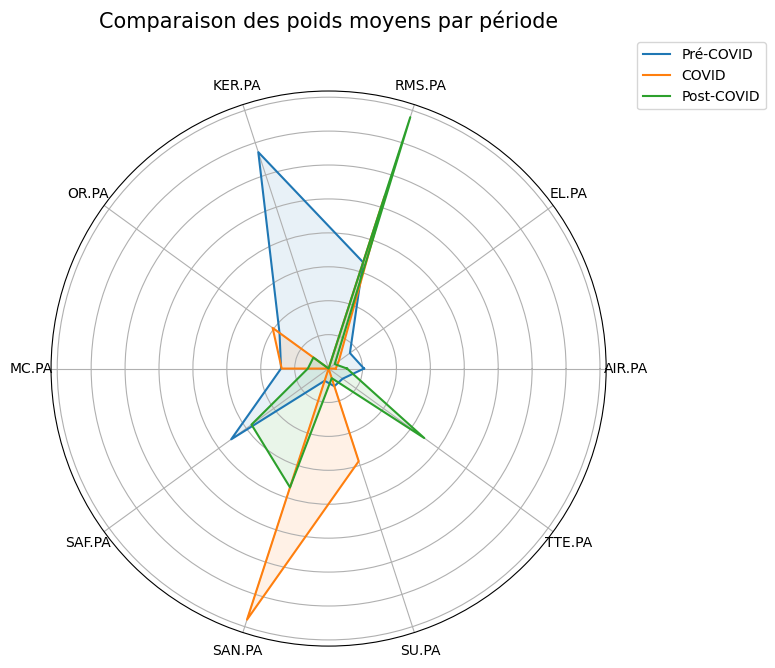

In [15]:
plot_allocation_radar(
    avg_weights_list=[avg_weights_pre, avg_weights_covid, avg_weights_post],
    labels=["Pré-COVID", "COVID", "Post-COVID"],
    tickers=tickers,
    title="Comparaison des poids moyens par période"
)